In [1]:
!pip install -q kaggle

In [2]:
# Import library utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model & evaluasi
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# One-hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hafizhanurulqolby","key":"f42a992f6133036a0659d5d7fa222a7b"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d mirichoi0218/insurance
!unzip insurance.zip

Dataset URL: https://www.kaggle.com/datasets/mirichoi0218/insurance
License(s): DbCL-1.0
  0% 0.00/16.0k [00:00<?, ?B/s]
100% 16.0k/16.0k [00:00<00:00, 65.9MB/s]
Archive:  insurance.zip
  inflating: insurance.csv           


In [6]:
# Load Data
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Data Understanding & EDA**

In [7]:
# Informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
# Statistik ringkasan
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [9]:
# Cek missing values
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


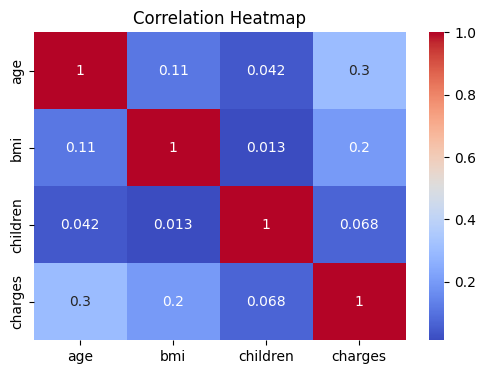

In [10]:
# Korelasi numerik
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Berdasarkan heatmap, fitur `age` dan `bmi` memiliki korelasi yang lemah dengan `charges`, sedangkan `children` memiliki korelasi yang sangat rendah. Korelasi tertinggi terhadap `charges` tercatat pada fitur `age` dengan nilai sekitar **0.3**. Hal ini menunjukkan bahwa hubungan linier antar fitur cukup lemah, namun tetap dapat dipertimbangkan dalam model regresi.

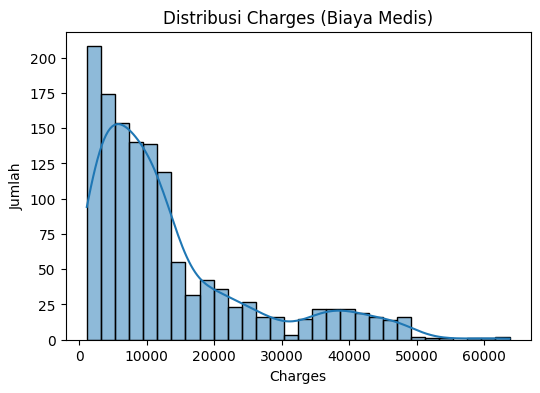

In [11]:
# Distribusi target
plt.figure(figsize=(6, 4))
sns.histplot(df['charges'], bins=30, kde=True)
plt.title("Distribusi Charges (Biaya Medis)")
plt.xlabel("Charges")
plt.ylabel("Jumlah")
plt.show()

Distribusi nilai `charges` terlihat **right-skewed**, dengan sebagian besar nilai berada di bawah 20.000. Terdapat beberapa outlier dengan nilai yang sangat tinggi hingga di atas 60.000. Kondisi ini penting untuk diperhatikan karena bisa mempengaruhi performa model regresi, terutama dalam hal generalisasi terhadap nilai ekstrem.

**Data Preparation**

In [12]:
# Pisahkan fitur dan target
X = df.drop('charges', axis=1)
y = df['charges']

In [13]:
# Fitur kategorikal untuk encoding
categorical_cols = ['sex', 'smoker', 'region']

In [14]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first'), categorical_cols)
], remainder='passthrough')

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Modelling**

a) Linear Regression (Baseline)

Pada tahap ini, kita akan melatih model regresi linear menggunakan pipeline yang terdiri dari dua komponen utama:


*   `preprocessor`: untuk melakukan preprocessing pada fitur input (misalnya scaling, encoding, dsb.)
*   `regressor`: model regresi linear (`LinearRegression`) dari Scikit-learn.

Model akan dilatih menggunakan data latih (`X_train`, `y_train`) dan kemudian digunakan untuk melakukan prediksi pada data uji (`X_test`).


In [16]:
lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

b) Random Forest Regressor

Pada tahap ini, kita melatih model menggunakan algoritma Random Forest Regressor yang merupakan model ansambel berbasis pohon keputusan. Model ini dibungkus dalam sebuah pipeline yang terdiri dari:

*   `preprocessor`: untuk preprocessing data (seperti normalisasi, encoding, dsb.), dan
*   `regressor`: yaitu `RandomForestRegressor` dengan 100 pohon keputusan (`n_estimators=100`) dan pengaturan `random_state=42` untuk memastikan hasil yang konsisten.

Model ini akan dilatih menggunakan data latih (`X_train`, `y_train`) dan digunakan untuk memprediksi nilai target pada data uji (`X_test`).



In [17]:
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

c) XGBoost Regressor

Langkah ini melibatkan pelatihan model menggunakan algoritma Extreme Gradient Boosting (`XGBoost`), yang dikenal unggul dalam menangani dataset kompleks dan sering digunakan dalam kompetisi data science. Model dibungkus dalam pipeline yang mencakup:


*   `preprocessor`: untuk menangani preprocessing data, dan
*   `regressor`: yaitu XGBRegressor dengan parameter `n_estimators=100` dan `learning_rate=0.1`.

`XGBoost` bekerja dengan membangun pohon keputusan secara bertahap (boosting) dan mengoptimalkan kesalahan model sebelumnya. Model dilatih pada data latih (`X_train`, `y_train`) dan kemudian digunakan untuk memprediksi data uji (`X_test`).

In [18]:
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

**Evaluasi Model**

In [19]:
def evaluate_model(name, y_true, y_pred):
    print(f"--- {name} ---")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R2  :", r2_score(y_true, y_pred))
    print()

# Evaluasi semua model
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)

--- Linear Regression ---
MAE : 4181.194473753643
RMSE: 5796.284659276275
R2  : 0.7835929767120722

--- Random Forest ---
MAE : 2554.3777592700917
RMSE: 4581.114617882647
R2  : 0.8648194356210239

--- XGBoost ---
MAE : 2567.3759500257843
RMSE: 4595.681477116327
R2  : 0.8639583844829724



Dengan mempertimbangkan keseluruhan metrik evaluasi, Random Forest menjadi model terbaik untuk memprediksi biaya medis berdasarkan profil pasien, karena memberikan kombinasi error rendah dan akurasi tinggi tanpa overfitting yang mencolok.

**Visualisasi**

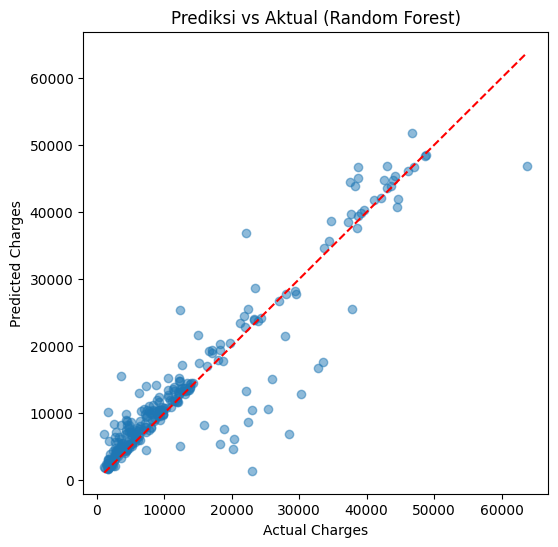

In [20]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Prediksi vs Aktual (Random Forest)")
plt.show()

Sebagian besar titik tersebar di sekitar garis merah, menunjukkan bahwa model mampu menghasilkan prediksi yang cukup mendekati nilai aktual.
Namun, terdapat beberapa titik outlier yang jauh dari garis, terutama pada nilai charges yang tinggi, yang mengindikasikan adanya potensi underprediction atau overprediction pada kasus ekstrem.

Secara keseluruhan, model Random Forest menunjukkan performa prediksi yang solid, terutama pada rentang nilai charges yang lebih umum, namun perlu perhatian khusus pada kasus nilai ekstrim.